In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.impute import KNNImputer

In [ ]:
#load data

In [ ]:
connections_df = pd.read_csv('data/connections.csv',delimiter='\t', on_bad_lines='skip')
processes_df = pd.read_csv('data/processes.csv',delimiter='\t', on_bad_lines='skip')
profiles_df = pd.read_csv('data/profiles.csv',delimiter='\t', on_bad_lines='skip')
devices_df = pd.read_csv('data/devices.csv',delimiter='\t', on_bad_lines='skip')

In [ ]:
#1)
#A) Analyze daata structures

In [ ]:
c1 = connections_df.columns
c2 = processes_df.columns
c3 = profiles_df.columns
c4 = devices_df.columns

print("connections :", c1)
print("processes :", c2)
print("profiles :", c3)
print("devices :", c4)

In [ ]:
print("\nSummary for connections:")
print(connections_df.describe())
print("\nSummary for processes:")
print(processes_df.describe())
print("\nSummary for profiles:")
print(profiles_df.describe())
print("\nSummary for devices:")
print(devices_df.describe())

In [ ]:
print("\nSummary for profiles:")
print(profiles_df.describe(exclude=np.number))
print("\nSummary for devices:")
print(devices_df.describe(exclude=np.number))

In [ ]:
print("\nInfo for connections:")
print(connections_df.info())
print("\nInfo for processes:")
print(processes_df.info())
print("\nInfo for profiles:")
print(profiles_df.info())
print("\nInfo for devices:")
print(devices_df.info())

In [ ]:
#Combine datasets
combined_df = connections_df.merge(processes_df, on='imei', how='inner')\
                            .merge(profiles_df, on='imei', how='inner')\
                            .merge(devices_df, on='imei', how='inner')
combined_df = combined_df.drop_duplicates()
print(combined_df.shape)

In [ ]:
#B) Attribute analysis
# We chose the selected attributes based on the correlation matrix, using ones that have high correlation with MWRA

In [ ]:
selected_attributes_connections = ['c.android.youtube', 'c.android.gm', 'c.android.chrome', 'c.katana', 'c.updateassist'] 
selected_attributes_processes = ['p.android.settings', 'p.android.packageinstaller', 'p.android.gm', 'p.system', 'p.android.externalstorage']

In [ ]:
def plot_and_describe(df, attributes):
        for attribute in attributes:
            sns.histplot(df[attribute], kde=True)
            plt.title(f'Distribution of {attribute}')
            plt.show()
            print(f'Descriptive statistics for {attribute}:')
            print(df[attribute].describe())

In [ ]:
plot_and_describe(connections_df, selected_attributes_connections)
plot_and_describe(processes_df, selected_attributes_processes)

In [ ]:
#C) Pair analysis

In [ ]:
connections_numeric_df = connections_df.select_dtypes(include=[np.number])
processes_numeric_df = processes_df.select_dtypes(include=[np.number])

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(connections_numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Correlation Heatmap for Connections Dataset")
plt.show()

In [ ]:
columns_to_exclude = ['c.UCMobile.x86', 'c.UCMobile.intl', 'c.raider', 'c.android.vending', 'imei']
filtered_connections_df = connections_numeric_df.drop(columns=columns_to_exclude)
sns.pairplot(filtered_connections_df)
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(processes_numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".1f")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Correlation Heatmap for Processes Dataset")
plt.show()

In [ ]:
columns_to_exclude = ['p.google', 'p.olauncher', 'p.android.gms', 'p.browser.provider', 'p.process.gapps', 'p.dogalize', 'p.android.vending', 'p.gms.persistent', 'p.android.defcontainer', 'p.simulator', 'p.notifier', 'p.inputmethod.latin', 'p.katana', 'imei']
filtered_processes_df = processes_numeric_df.drop(columns=columns_to_exclude)
sns.pairplot(filtered_processes_df)
plt.show()

In [ ]:
#D) Pair analysis focused on predicted attribute

In [ ]:
def analyze_correlations(df, target_column):
    correlations = df.corr()[target_column].sort_values()
    print(f"Correlations with {target_column}:\n", correlations)
    return correlations

In [ ]:
def plot_predictor_relationships(df, target_column, predictors):
    for predictor in predictors:
        sns.scatterplot(x=df[predictor], y=df[target_column])
        plt.title(f'Relation between {predictor} and {target_column}')
        plt.show()

In [ ]:
def fit_ols_model(df, predictors, target_column):
    X = df[predictors]
    y = df[target_column]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(model.summary())
    return model

In [ ]:
connections_correlations = analyze_correlations(connections_numeric_df, 'mwra')
connections_potential_predictors = connections_correlations.index[-5:]
plot_predictor_relationships(connections_df, 'mwra', connections_potential_predictors)
fit_ols_model(connections_df, connections_potential_predictors, 'mwra')

In [ ]:
processes_correlations = analyze_correlations(processes_numeric_df, 'mwra')
processes_potential_predictors = processes_correlations.index[-5:]
plot_predictor_relationships(processes_df, 'mwra', processes_potential_predictors)
fit_ols_model(processes_df, processes_potential_predictors, 'mwra')

In [ ]:
#2
#A identification of problems in data

In [ ]:
print("Duplicated records in connections:", connections_df.duplicated().sum())
print("Duplicated records in processes:", processes_df.duplicated().sum())
print("Duplicated records in profiles:", profiles_df.duplicated().sum())
print("Duplicated records in devices:", devices_df.duplicated().sum())

In [ ]:
#Check missing values
print("Rows with missing values in connections:", connections_df[connections_df.isnull().any(axis=1)].shape[0])
print("Rows with missing values in processes:", processes_df[processes_df.isnull().any(axis=1)].shape[0])
print("Rows with missing values in profiles:", profiles_df[profiles_df.isnull().any(axis=1)].shape[0])
print("Rows with missing values in devices:", devices_df[devices_df.isnull().any(axis=1)].shape[0])
print("\nMissing values in profiles:")
print(profiles_df.isnull().sum())

In [57]:
def convert_to_numeric(df, df_name):
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                print(f"{df_name} - Non-numeric values found in column {col}")
    return df

In [58]:
connections_df = convert_to_numeric(connections_df, "Connections")
processes_df = convert_to_numeric(processes_df, "Processes")
devices_df = convert_to_numeric(devices_df, "Devices")
profiles_df = convert_to_numeric(profiles_df, "Profiles")

Connections - Non-numeric values found in column ts
Processes - Non-numeric values found in column ts
Devices - Non-numeric values found in column store_name
Devices - Non-numeric values found in column code
Devices - Non-numeric values found in column location
Profiles - Non-numeric values found in column username
Profiles - Non-numeric values found in column registration
Profiles - Non-numeric values found in column name
Profiles - Non-numeric values found in column birthdate
Profiles - Non-numeric values found in column current_location
Profiles - Non-numeric values found in column ssn
Profiles - Non-numeric values found in column address
Profiles - Non-numeric values found in column company
Profiles - Non-numeric values found in column job
Profiles - Non-numeric values found in column mail


In [59]:
def generate_boxplots(df, df_name):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col} ({df_name})')
        plt.show()

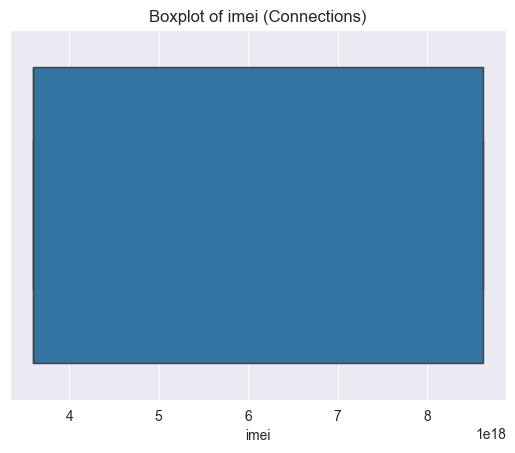

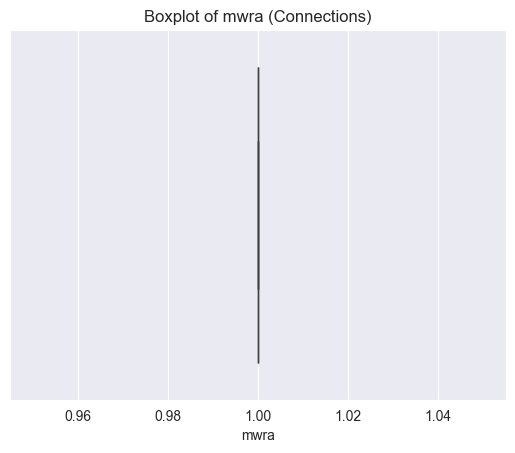

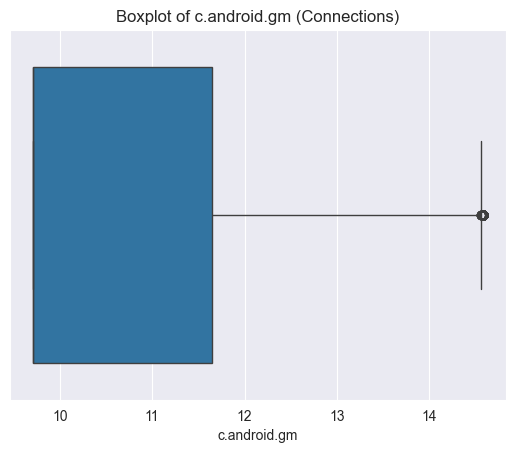

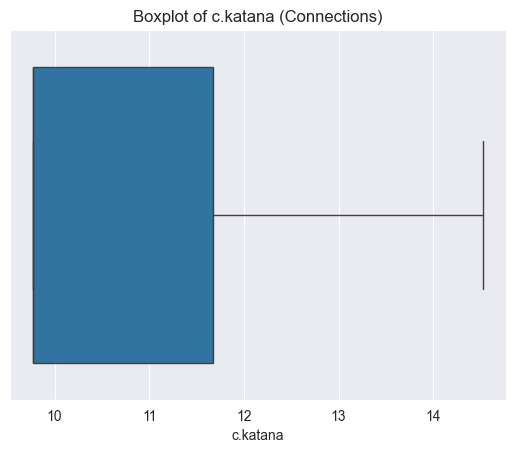

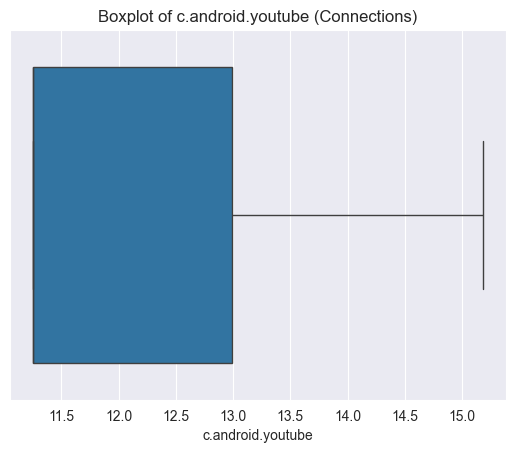

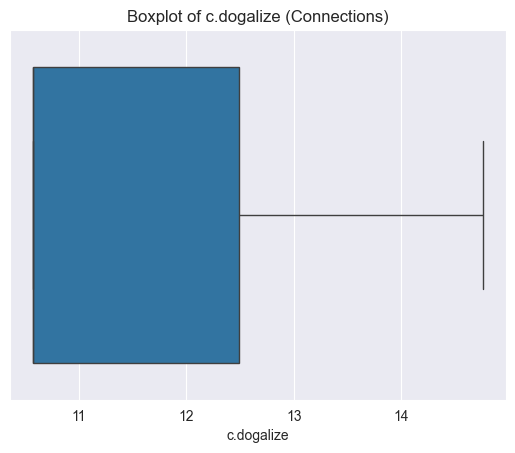

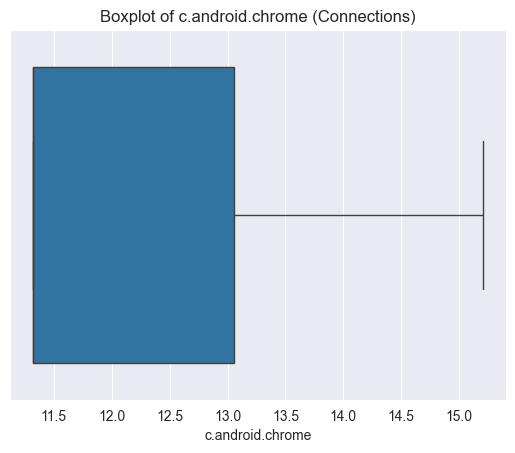

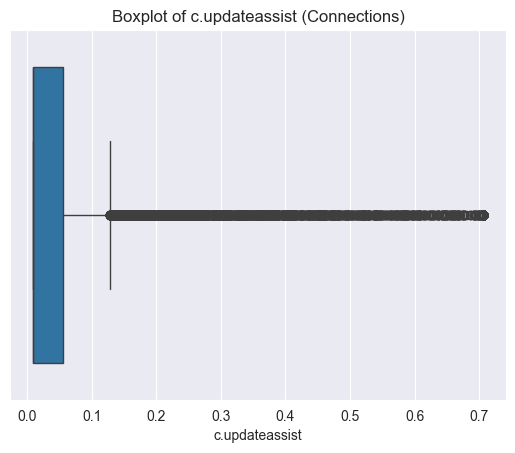

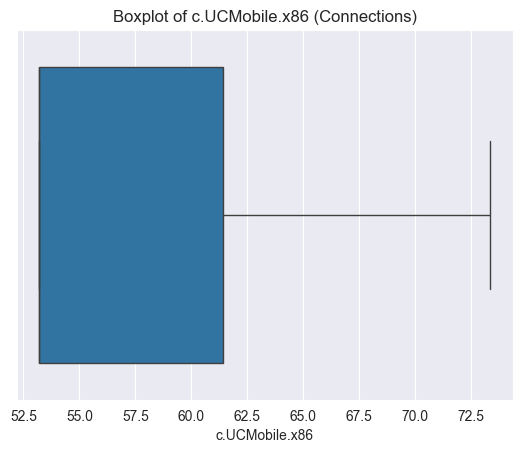

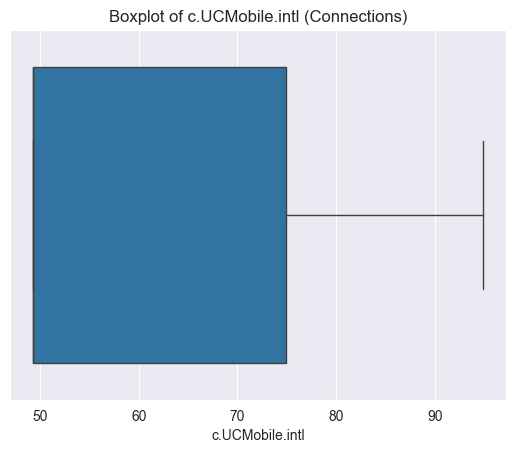

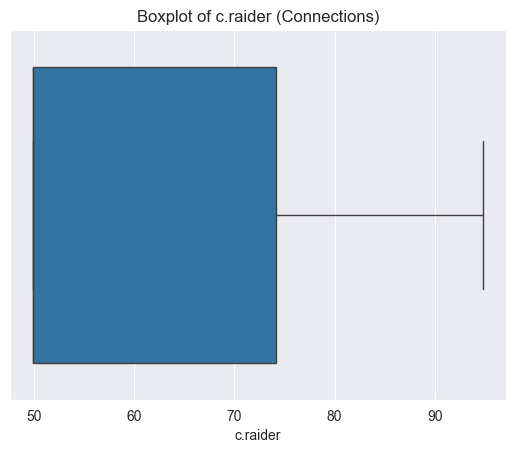

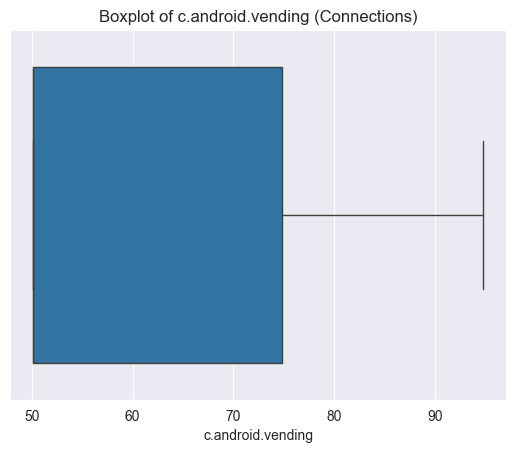

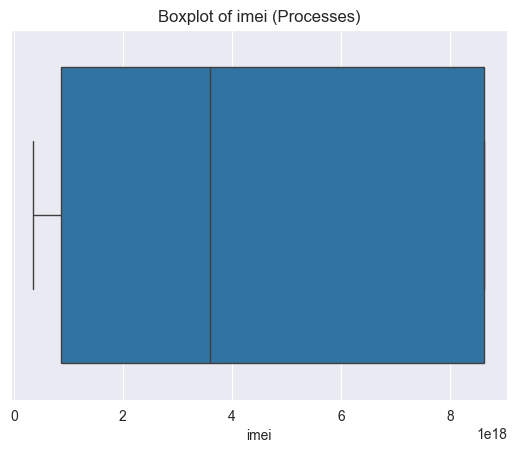

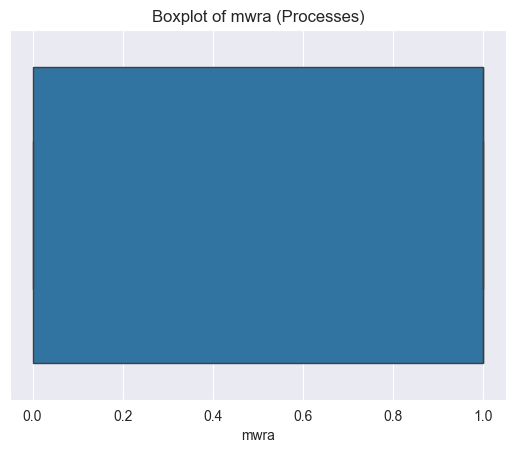

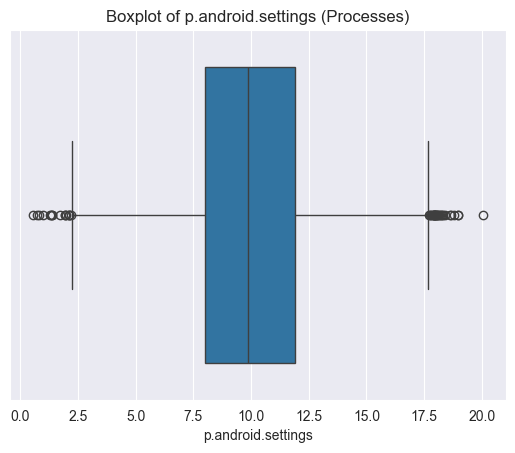

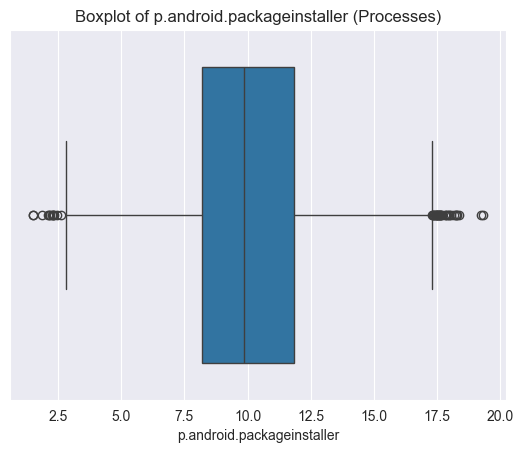

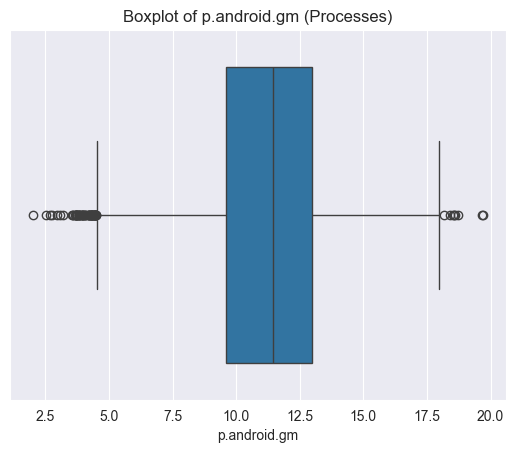

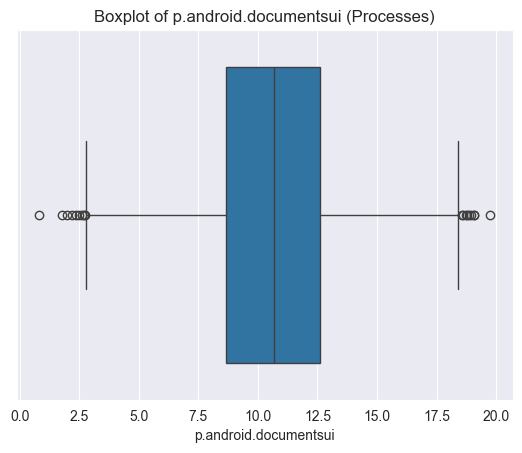

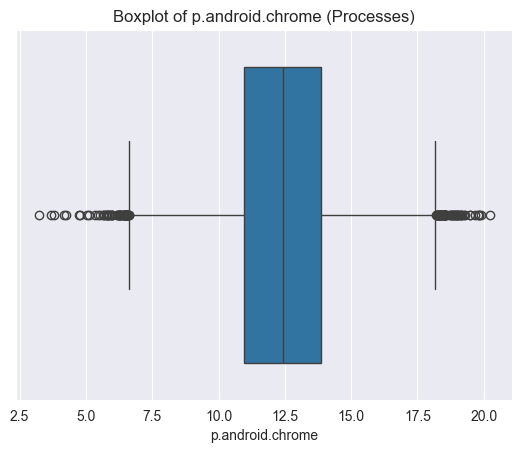

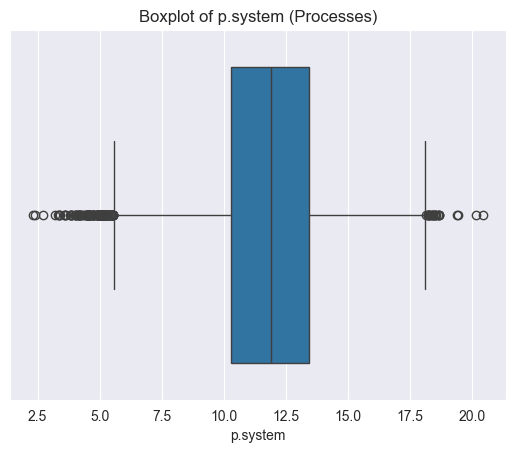

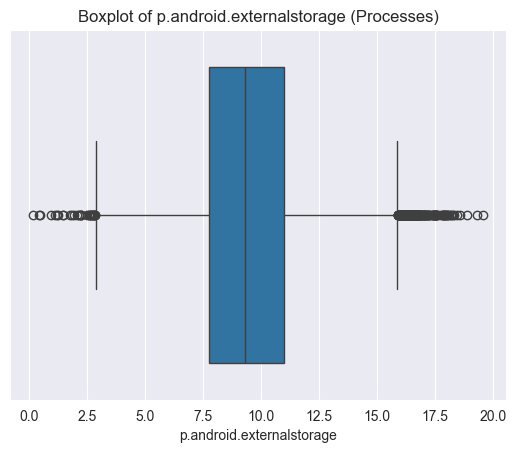

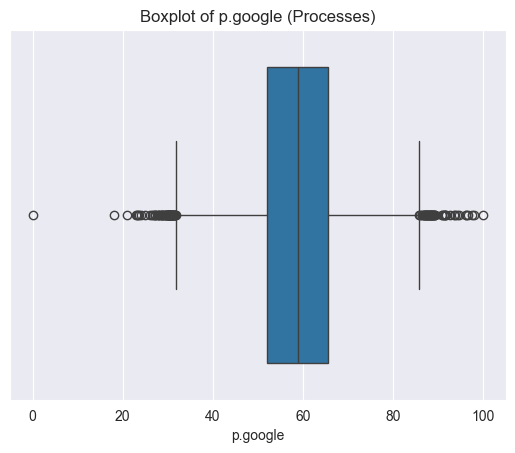

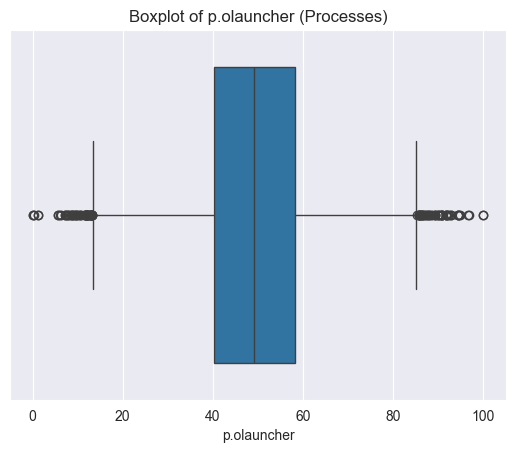

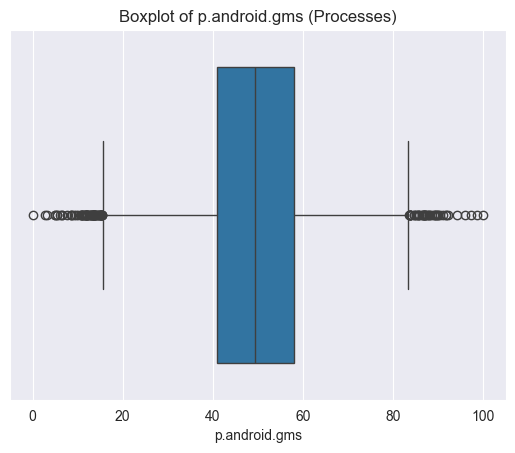

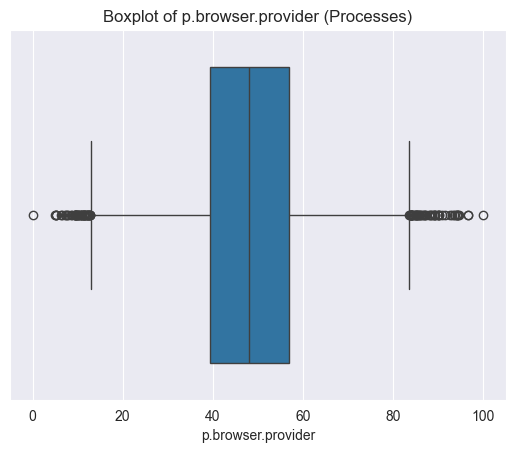

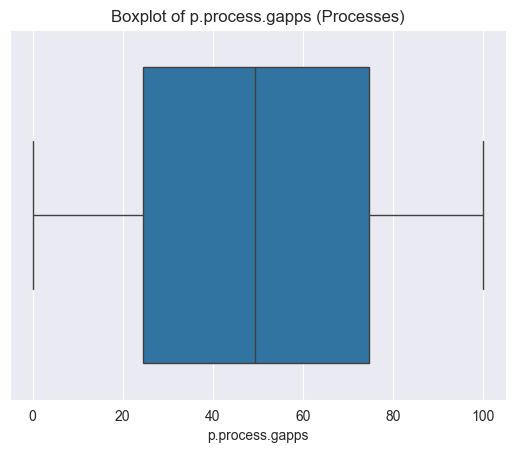

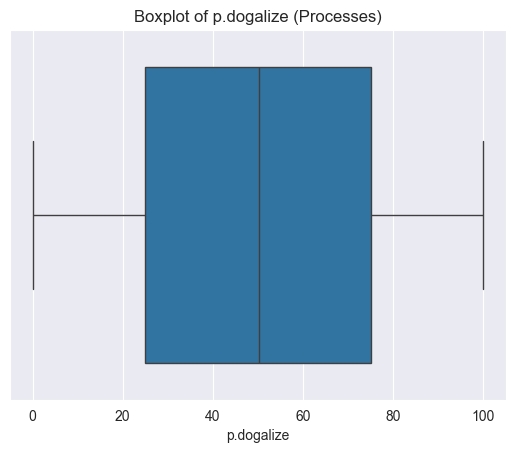

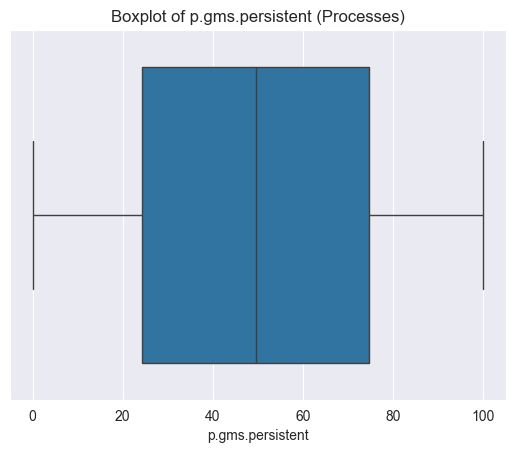

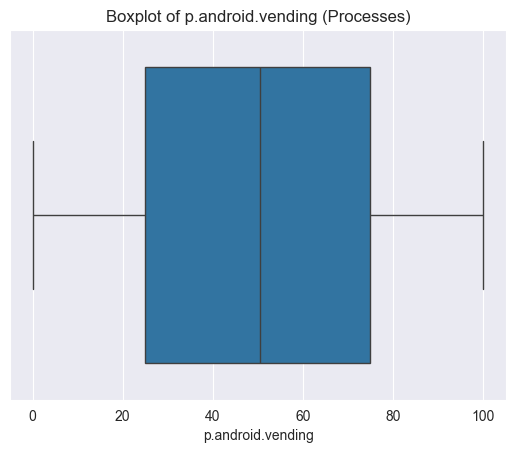

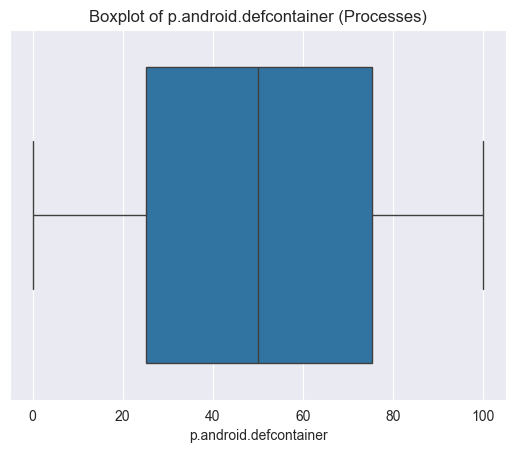

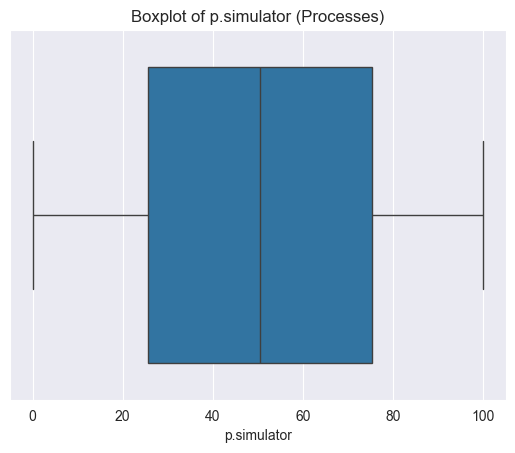

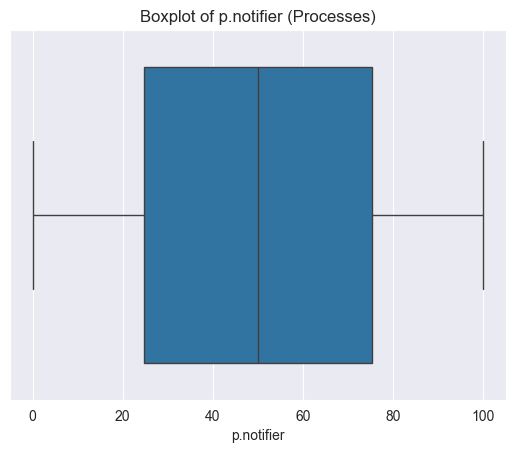

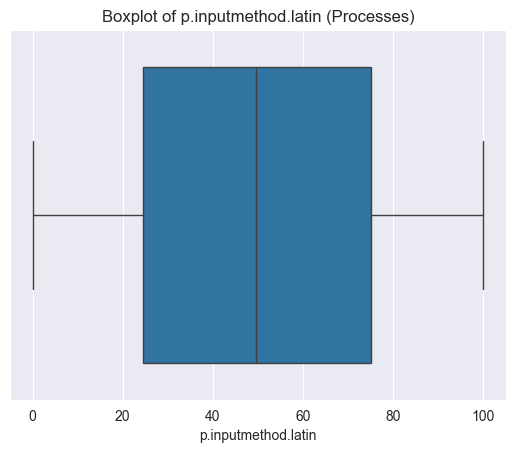

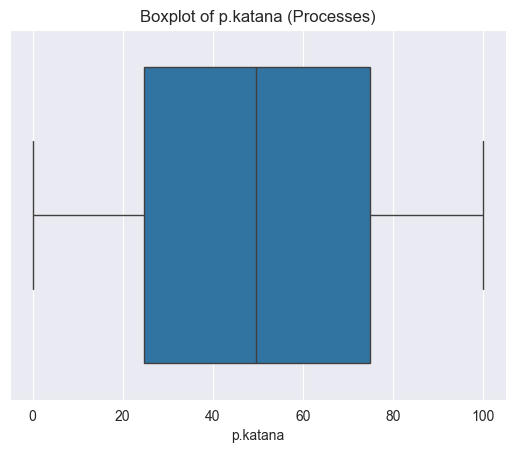

In [60]:
generate_boxplots(connections_df, "Connections")
generate_boxplots(processes_df, "Processes")

In [ ]:
#B) Missing values

In [ ]:
#set treshold as 0.05 -> 5%
#set impute method to knn or mean
def handle_missing_values(df, threshold, impute_method):
    df = df.dropna(thresh=int(len(df) * threshold), axis=1)

    #essential_columns = ['mwra'] 
    #df = df.dropna(subset=essential_columns)
    
    if impute_method == 'mean':
        for col in df.select_dtypes(include=[np.number]).columns:
            df[col] = df[col].fillna(df[col].mean())
    elif impute_method == 'knn':
        knn_imputer = KNNImputer(n_neighbors=5)
        df[df.select_dtypes(include=[np.number]).columns] = knn_imputer.fit_transform(df.select_dtypes(include=[np.number]))
    
    return df

In [ ]:
missing_handled_connections = handle_missing_values(connections_df, 0.05, 'mean') 
print("Rows with missing values in profiles:", profiles_df[profiles_df.isnull().any(axis=1)].shape[0])
m_profiles_df = handle_missing_values(profiles_df, 0.85, '') # can not replace values since they are not numeric 
print("Rows with missing values in profiles:", m_profiles_df[m_profiles_df.isnull().any(axis=1)].shape[0])

In [ ]:
#C) Outlier detection

In [ ]:
#method = remove / replace 
#lower_quantile = 0.5
#upper_quartile = 0.95

def handle_outliers(df, method, lower_quantile, upper_quantile):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        lower_bound = df[col].quantile(lower_quantile)
        upper_bound = df[col].quantile(upper_quantile)
        
        if method == 'remove':
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        elif method == 'replace':
            df[col] = np.where(df[col] < lower_bound, lower_bound, 
                               np.where(df[col] > upper_bound, upper_bound, df[col]))
    
    return df

In [ ]:
o_connections_df = handle_outliers(connections_df, 'replace', 0.5, 0.95)
print(connections_df.info())
print(o_connections_df.info())
